# Seattle Housing Prices - Predictive Modeling

### Workflow:

1. Feature Engineering
    - (a) Create dummy variables
    - (b) Adjusting year_renovated column as categorical (yes or no) rather than by date
    - (c) Drop sqft_lot and sqft_lot15
    
    
2. Create Train_Test_Split


3. Run baseline model
    - print RMSE


4. Iterate on model:
    - (a) Remove outliers
    - (b) Remove collinear variables
    - (c) Log transformations
    - (d) Drop non-sig p-values
    - (e) Unit Vectorization (update x-columns to add in unit vectors composed of collinear variables)
    
 

### Plan so far...

#### Dependent Variable:

    - Price

#### Explanatory Variables:

    - Keep: ['bedrooms',
             'bathrooms',
             'sqft_living',
             'floors',
             'sqft_above',
             'sqft_basement',
             'sqft_living15',
             'view',
             'waterfront',
             'yr_built]
    
    - Drop: ['sqft_lot', 'sqft_lot15']
    
    - Create dummies: ['condition', 'zipcode', 'grade']
    
    - Convert to binary: ['yr_renovated']
    
    - Will have to think of a plan for latitude and longitude

In [102]:
# Thoughts for another time... so using city data instead of Zipcode dropped R2 and increased RMSE by about 20k.
# ... but it's better practice to drop the predictors by 46... 
# I suppose try it out this way for now instead of using zip - go by city

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from uszipcode import SearchEngine, SimpleZipcode, Zipcode
search = SearchEngine()

#### Import and drop columns:

In [208]:
house_data = pd.read_csv('house_data_cleaned.csv')
house_data.drop(['sqft_lot', 'sqft_lot15'], axis=1, inplace=True)
house_data.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
0,221900.0,3,1.00,1180,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800


#### Create dummy variables:

In [209]:
def zco(x):
    city = search.by_zipcode(x).city 
    return city if city else x  # if city is None for certain zipcodes, take advantage of the truthiness of None

In [210]:
house_data['city'] = house_data['zipcode'].apply(zco)

In [211]:
# Drop first variable so they do not reference one another
# grade_dum = pd.get_dummies(house_data['grade'], prefix='grade_', drop_first=True)
# view_dum = pd.get_dummies(house_data['view'], prefix='view_', drop_first=True)
# zipcode_dum = pd.get_dummies(house_data['zipcode'], prefix='zipcode_', drop_first=True)
city_dum = pd.get_dummies(house_data['city'], prefix='city', drop_first=True)
# zipcode_dum.head()

In [213]:
# Now to merge dummy columns onto our dataframe
upHouse_data = pd.concat([house_data, city_dum], axis=1)
upHouse_data.drop(columns=['zipcode', 'city'], inplace=True)
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21597 non-null  float64
 1   bedrooms            21597 non-null  int64  
 2   bathrooms           21597 non-null  float64
 3   sqft_living         21597 non-null  int64  
 4   floors              21597 non-null  float64
 5   waterfront          21597 non-null  float64
 6   view                21597 non-null  float64
 7   condition           21597 non-null  int64  
 8   grade               21597 non-null  int64  
 9   sqft_above          21597 non-null  int64  
 10  sqft_basement       21597 non-null  float64
 11  yr_built            21597 non-null  int64  
 12  yr_renovated        21597 non-null  float64
 13  lat                 21597 non-null  float64
 14  long                21597 non-null  float64
 15  sqft_living15       21597 non-null  int64  
 16  city

In [214]:
# Create a binary renovated column to determine whether the home was renovated or not
# Since the year renovated is not actionable unless we specialize in selling renovated homes from specific years
# but this way we can determine whether we should focus on renovations or not
upHouse_data['yr_renovated'] = upHouse_data.yr_renovated.apply(lambda x: 1 if x > 0 else 0)
upHouse_data.rename(columns = {"yr_renovated":"renovated"}, inplace=True)

In [215]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.7) & (coral.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(bathrooms, sqft_living)",0.755758
"(sqft_above, sqft_living15)",0.731767
"(sqft_living15, grade)",0.713867
"(city_Seattle, long)",0.709844
"(sqft_living, price)",0.701917


In [216]:
# drop squarefoot above. Maybe interaction with squarefoot living and living15
upHouse_data.drop('sqft_above', axis=1, inplace=True)

In [217]:
upHouse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               21597 non-null  float64
 1   bedrooms            21597 non-null  int64  
 2   bathrooms           21597 non-null  float64
 3   sqft_living         21597 non-null  int64  
 4   floors              21597 non-null  float64
 5   waterfront          21597 non-null  float64
 6   view                21597 non-null  float64
 7   condition           21597 non-null  int64  
 8   grade               21597 non-null  int64  
 9   sqft_basement       21597 non-null  float64
 10  yr_built            21597 non-null  int64  
 11  renovated           21597 non-null  int64  
 12  lat                 21597 non-null  float64
 13  long                21597 non-null  float64
 14  sqft_living15       21597 non-null  int64  
 15  city_Bellevue       21597 non-null  uint8  
 16  city

### Now Train-Test-Split

... in preparation for our baseline model

In [218]:
# Your code here - Define the target and predictors
outcome = 'price'
feat_cols = list(upHouse_data.columns)
feat_cols.remove(outcome)

In [219]:
X = upHouse_data[feat_cols]
y = upHouse_data['price']

In [220]:
# Initial test-size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)
print(len(X_train), len(y_test))
X_train.head()

15117 6480


,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,...,city_Medina,city_Mercer Island,city_North Bend,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville
4900,3,1.00,1200,1.0,0.0,0.0,4,7,0.0,1969,...,0,0,0,0,0,0,0,0,0,0
19664,3,2.50,1920,1.0,0.0,0.0,3,8,0.0,2014,...,0,0,0,0,0,0,0,0,0,0
13949,3,1.75,1590,1.5,0.0,0.0,4,6,0.0,1926,...,0,0,0,0,0,0,0,0,0,0
15272,4,4.00,2530,3.0,0.0,2.0,3,9,430.0,2013,...,0,0,0,0,0,0,1,0,0,0
14411,3,2.50,2010,2.0,0.0,0.0,3,8,620.0,2014,...,0,0,0,0,0,0,0,0,0,0


In [221]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

### Vanilla Model

#### Side Note: Model Function

In [222]:
# I don't need those predictors/formulas
def training_model(predictor_cols, outcome, y_train, X_train):
    predictors = '+'.join(predictor_cols)
    formula = outcome + '~' + predictors
    model_vanilla = sm.OLS(y_train, X_train).fit()
    return model_vanilla.summary()

In [223]:
training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:38:48   Log-Likelihood:            -2.0450e+05
No. Observations:               15117   AIC:                         4.091e+05
Df Residuals:                   15079   BIC:                         4.094e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7.214e+07   4.41e+06    -16.345      0.000   -8.08e+07   -6.35e+07
bedrooms            -3.17e+04   2017.750    -15.710      0.000   -3.57e+04   -2.77e+04
bathrooms           3.138e+04   3516.197      8.925      0.000    2.45e+04    3.83e+04
sqft_living          175.5530      3.949     44.456      0.000     167.813     183.293
floors              1.382e+04   3982.938      3.470      0.001    6015.382    2.16e+04
waterfront          6.472e+05   1.93e+04     33.552      0.000    6.09e+05    6.85e+05
view                4.819e+04   2297.781     20.971      0.000    4.37e+04    5.27e+04
condition           2.071e+04   2561.172      8.087      0.000    1.57e+04    2.57e+04
grade               8.448e+04   2383.436     35.444      0.000    7.98e+04    8.92e+04
sqft_basement        -34.4598      4.706     -7.322      0.000     -43.685     -25.235
yr_built           -2045.2144     81.023    -25.242      0.000   -2204.029   -1886.400
renovated           2.243e+04   8592.936      2.611      0.009    5591.178    3.93e+04
lat                 5.836e+05   2.32e+04     25.193      0.000    5.38e+05    6.29e+05
long               -3.913e+05   3.57e+04    -10.971      0.000   -4.61e+05   -3.21e+05
sqft_living15         20.4984      3.841      5.336      0.000      12.969      28.028
city_Bellevue       2.198e+05    1.2e+04     18.309      0.000    1.96e+05    2.43e+05
city_Black Diamond  1.401e+05   2.42e+04      5.784      0.000    9.26e+04    1.88e+05
city_Bothell       -1.481e+05   1.99e+04     -7.442      0.000   -1.87e+05   -1.09e+05
city_Carnation      5.971e+04   2.69e+04      2.217      0.027    6908.071    1.13e+05
city_Duvall        -4.879e+04   2.28e+04     -2.138      0.033   -9.35e+04   -4061.842
city_Enumclaw       1.723e+05   1.84e+04      9.377      0.000    1.36e+05    2.08e+05
city_Fall City      1.556e+05   2.81e+04      5.540      0.000    1.01e+05    2.11e+05
city_Federal Way   -7.927e+04   1.16e+04     -6.816      0.000   -1.02e+05   -5.65e+04
city_Issaquah       1.026e+05   1.42e+04      7.215      0.000    7.47e+04    1.31e+05
city_Kenmore       -1.633e+05    1.8e+04     -9.068      0.000   -1.99e+05   -1.28e+05
city_Kent          -5520.2711   9986.718     -0.553      0.580   -2.51e+04    1.41e+04
city_Kirkland         4.1e+04   1.37e+04      2.986      0.003    1.41e+04    6.79e+04
city_Maple Valley   7.379e+04   1.36e+04      5.438      0.000    4.72e+04       1e+05
city_Medina          9.32e+05   3.26e+04     28.572      0.000    8.68e+05    9.96e+05
city_Mercer Island   3.37e+05   1.64e+04     20.608      0.000    3.05e+05    3.69e+05
city_North Bend      1.82e+05    2.4e+04      7.571      0.000    1.35e+05    2.29e+05
city_Redmond        3.829e+04   1.46e+04      2.631      0.009    9758.506    6.68e+04
city_Renton        -1.108e+04   1.02e+

In [126]:
# We see a very high R-squared and large standard errors, likely because of collinearity
# During our EDA, we noted there were several collinear variable pairs to be addressed

With our QQ plot for the vanilla model above, we can see that the graph is not normal with heavy skew on both low and high ends. The upper end has a greater skew showing there are likely a large number of outliers on this end.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. If we were doing so, we would have to narrow our data set to these alone.

In [224]:
model_vanilla = sm.OLS(y_train, X_train).fit()

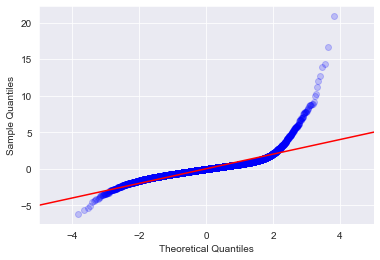

In [225]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_vanilla.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [226]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_vanilla.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_vanilla.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))


Train RMSE: 181471.70886246453 
 Test RMSE: 190645.07025761876
Percent change:  5.055


In [227]:
# Our test model is actually not far off, especially for the vanilla model.
# That being said, RMSE seems high. I think we can bring this down...
# especially by removing outliers and collinearity

### Model 2: Removing Outliers

In [228]:
# Going to remove outliers based on 2 standard deviations (95%)
# This is because our business focus is not on the most expensive or the cheapest homes.
# So in order to improve our model's prediction for relevant prices, we'll narrow our scope
# Down the line, I'd like to look at zipcodes and schools/bus stop data to see if that correlates with price
# If so, maybe we focus on those homes.
# Otherwise, let's see how renovations predicts pricing

Based on the results below for standard deviation of pricing, it would be inaccurate to filter our training and testing sets based on their own respective standard deviation since they will differ.

Therefore, to maintain consistency without training the original training set, we will filter both training and testing data based on 2 standard deviations from the mean from the overall dataset. This is effectively the same results as removing the pricing outliers before train_test_split.

In [229]:
# Here is our code for filtering the training set based on 2 std from full dataset
# We can see the before and after to verify that outliers have been trimmed
mean_price = np.mean(upHouse_data.price, axis=0)
sd_price = np.std(upHouse_data.price, axis=0)

final_y_train_list = [y for y in y_train if (y > mean_price - 2 * sd_price)]
final_y_train_list = [y for y in final_y_train_list if (y < mean_price + 2 * sd_price)]
y_train_2std = pd.Series(final_y_train_list)

#### Comparison of y_train set before and after filtering for 2 standard deviations for price from the full dataset:

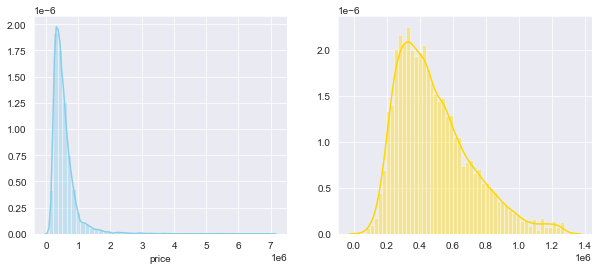

In [230]:
f, axes = plt.subplots(1, 2, figsize=(10,4));
sns.distplot(y_train, color="skyblue", ax=axes[0])
sns.distplot(y_train_2std, color="gold", ax=axes[1]);

In [231]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
# Practicing on dataset. Will then apply to our y_train/y_test data 
upHouse_data_2std = upHouse_data[np.abs(stats.zscore(upHouse_data.price)) < 2]

# How many rows were removed & how many rows are left
print(len(upHouse_data.index.difference(upHouse_data_2std.index)))
len(upHouse_data_2std)

841


20756

In [232]:
X = upHouse_data_2std[feat_cols]
y = upHouse_data_2std['price']

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [234]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [235]:
training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:39:06   Log-Likelihood:            -1.8934e+05
No. Observations:               14529   AIC:                         3.788e+05
Df Residuals:                   14491   BIC:                         3.791e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.255e+07   2.78e+06    -18.906      0.000    -5.8e+07   -4.71e+07
bedrooms           -1.084e+04   1281.277     -8.459      0.000   -1.33e+04   -8326.498
bathrooms           2.311e+04   2245.168     10.291      0.000    1.87e+04    2.75e+04
sqft_living           93.3585      2.675     34.897      0.000      88.115      98.602
floors              2.685e+04   2518.774     10.658      0.000    2.19e+04    3.18e+04
waterfront          1.448e+05   1.82e+04      7.958      0.000    1.09e+05     1.8e+05
view                3.262e+04   1542.761     21.141      0.000    2.96e+04    3.56e+04
condition           2.306e+04   1596.066     14.450      0.000    1.99e+04    2.62e+04
grade               6.476e+04   1519.854     42.608      0.000    6.18e+04    6.77e+04
sqft_basement        -16.7974      3.103     -5.413      0.000     -22.880     -10.715
yr_built           -1524.7416     51.046    -29.870      0.000   -1624.798   -1424.685
renovated           2.919e+04   5622.858      5.192      0.000    1.82e+04    4.02e+04
lat                 5.063e+05   1.43e+04     35.449      0.000    4.78e+05    5.34e+05
long                -2.54e+05   2.24e+04    -11.338      0.000   -2.98e+05    -2.1e+05
sqft_living15         44.2988      2.538     17.451      0.000      39.323      49.274
city_Bellevue       1.694e+05   7418.118     22.831      0.000    1.55e+05    1.84e+05
city_Black Diamond  1.455e+05   1.43e+04     10.151      0.000    1.17e+05    1.74e+05
city_Bothell       -9.432e+04   1.23e+04     -7.664      0.000   -1.18e+05   -7.02e+04
city_Carnation      3.806e+04   1.62e+04      2.350      0.019    6316.875    6.98e+04
city_Duvall        -3.937e+04   1.36e+04     -2.903      0.004    -6.6e+04   -1.28e+04
city_Enumclaw       1.216e+05   1.09e+04     11.119      0.000       1e+05    1.43e+05
city_Fall City      1.159e+05   1.78e+04      6.497      0.000     8.1e+04    1.51e+05
city_Federal Way   -5.322e+04   7070.909     -7.527      0.000   -6.71e+04   -3.94e+04
city_Issaquah       1.234e+05   8728.199     14.142      0.000    1.06e+05    1.41e+05
city_Kenmore       -1.078e+05   1.09e+04     -9.873      0.000   -1.29e+05   -8.64e+04
city_Kent          -9060.0853   6055.580     -1.496      0.135   -2.09e+04    2809.625
city_Kirkland        4.75e+04   8418.070      5.643      0.000     3.1e+04     6.4e+04
city_Maple Valley   6.038e+04   8290.750      7.283      0.000    4.41e+04    7.66e+04
city_Medina         4.732e+05   3.97e+04     11.918      0.000    3.95e+05    5.51e+05
city_Mercer Island  2.754e+05   1.12e+04     24.587      0.000    2.53e+05    2.97e+05
city_North Bend     1.535e+05   1.49e+04     10.310      0.000    1.24e+05    1.83e+05
city_Redmond        8.923e+04   8856.497     10.075      0.000    7.19e+04    1.07e+05
city_Renton         3453.0436   6199.8

In [236]:
model_outliers = sm.OLS(y_train, X_train).fit()

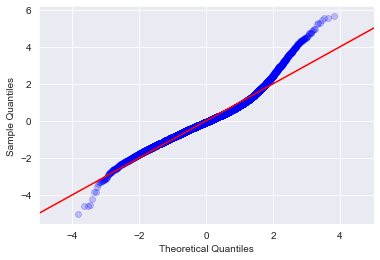

In [237]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_outliers.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [238]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_outliers.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_outliers.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((90380.9479527678-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 110551.160135469 
 Test RMSE: 110795.03388928871
Percent change:  0.221
Percent change (Base Model vs. Model-Outliers Removed):  -42.753


Adjusted R-squared improved by .003 to .836

RMSE decreased by 42.753% showing significant error reduction

### Model: Further Price Narrowing

In [239]:
upHouse_data_prim = upHouse_data_2std[upHouse_data_2std['price'] <= 790000]

In [240]:
X = upHouse_data_prim[feat_cols]
y = upHouse_data_prim['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     858.8
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:39:16   Log-Likelihood:            -1.6557e+05
No. Observations:               12958   AIC:                         3.312e+05
Df Residuals:                   12920   BIC:                         3.315e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.449e+07    2.3e+06    -19.358      0.000    -4.9e+07      -4e+07
bedrooms           -1.031e+04   1150.999     -8.953      0.000   -1.26e+04   -8049.234
bathrooms           2.161e+04   1900.832     11.371      0.000    1.79e+04    2.53e+04
sqft_living           70.9515      2.423     29.279      0.000      66.202      75.702
floors              2.183e+04   2097.367     10.409      0.000    1.77e+04    2.59e+04
waterfront          9.014e+04   1.83e+04      4.924      0.000    5.43e+04    1.26e+05
view                2.249e+04   1474.558     15.255      0.000    1.96e+04    2.54e+04
condition           2.094e+04   1298.610     16.125      0.000    1.84e+04    2.35e+04
grade                 4.9e+04   1304.761     37.554      0.000    4.64e+04    5.16e+04
sqft_basement         -8.7623      2.731     -3.209      0.001     -14.115      -3.410
yr_built           -1096.0593     43.376    -25.269      0.000   -1181.083   -1011.035
renovated           9259.5551   4879.451      1.898      0.058    -304.889    1.88e+04
lat                 4.508e+05   1.14e+04     39.475      0.000    4.28e+05    4.73e+05
long                -2.04e+05   1.86e+04    -10.996      0.000    -2.4e+05   -1.68e+05
sqft_living15         39.0590      2.242     17.425      0.000      34.665      43.453
city_Bellevue       1.334e+05   6257.900     21.309      0.000    1.21e+05    1.46e+05
city_Black Diamond   1.43e+05   1.18e+04     12.086      0.000     1.2e+05    1.66e+05
city_Bothell       -5.876e+04   9810.609     -5.989      0.000    -7.8e+04   -3.95e+04
city_Carnation      4.214e+04   1.28e+04      3.298      0.001    1.71e+04    6.72e+04
city_Duvall        -2.972e+04    1.1e+04     -2.702      0.007   -5.13e+04   -8159.092
city_Enumclaw       1.107e+05   8664.785     12.780      0.000    9.38e+04    1.28e+05
city_Fall City      1.009e+05   1.49e+04      6.784      0.000    7.18e+04     1.3e+05
city_Federal Way   -4.604e+04   5487.648     -8.390      0.000   -5.68e+04   -3.53e+04
city_Issaquah       1.312e+05   7049.200     18.614      0.000    1.17e+05    1.45e+05
city_Kenmore       -7.597e+04   8636.836     -8.796      0.000   -9.29e+04    -5.9e+04
city_Kent          -1.202e+04   4660.857     -2.579      0.010   -2.12e+04   -2886.626
city_Kirkland        3.43e+04   6846.425      5.010      0.000    2.09e+04    4.77e+04
city_Maple Valley    5.66e+04   6519.523      8.682      0.000    4.38e+04    6.94e+04
city_Medina         4.028e+05    8.6e+04      4.686      0.000    2.34e+05    5.71e+05
city_Mercer Island  2.221e+05   1.31e+04     16.925      0.000    1.96e+05    2.48e+05
city_North Bend     1.311e+05   1.18e+04     11.131      0.000    1.08e+05    1.54e+05
city_Redmond        9.989e+04   7180.607     13.912      0.000    8.58e+04    1.14e+05
city_Renton         5742.1077   4812.6

In [241]:
model_prim = sm.OLS(y_train, X_train).fit()

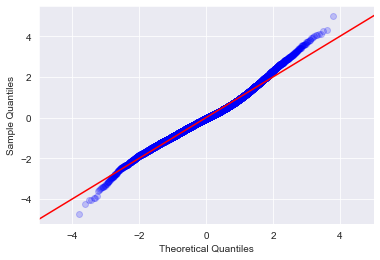

In [242]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_prim.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [181]:
# QQ Plot has heavy tails especially on the high-end. 
# Further trimming may be warranted. But first, let's work with what we got.

In [243]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_prim.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_prim.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 85664.9633437113 
 Test RMSE: 87449.62358731775
Percent change:  2.083
Percent change (Base Model vs. Model-Outliers Removed):  -44.609


Woah... that's better than I thought it would be. Slight decrease in R-squared but reduced error and close predictions between train and test sets.

Improved normalcy shown in QQ plot with further price trimming.

In [244]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data_prim.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.7) & (coral.cc<1)]

,cc
pairs,
"(sqft_living15, sqft_living)",0.707864


### Model: Interactions

In [245]:
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%run -i "functions/interactions.py"
%run -i "functions/plot_interactions.py"


Testing 703 combinations.

R^2 including interaction of long and city_Seattle: 0.718


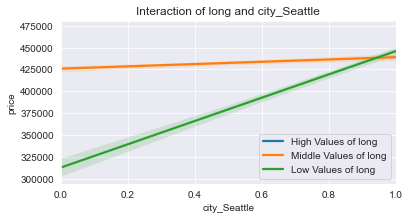

*********************

R^2 including interaction of lat and city_Kirkland: 0.717


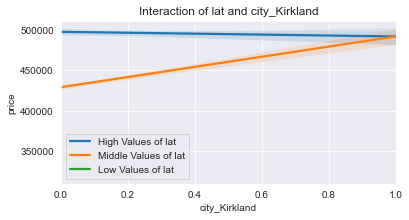

*********************

R^2 including interaction of yr_built and long: 0.715


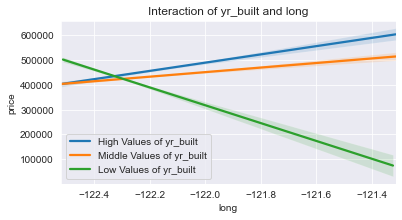

*********************

R^2 including interaction of grade and city_Seattle: 0.715


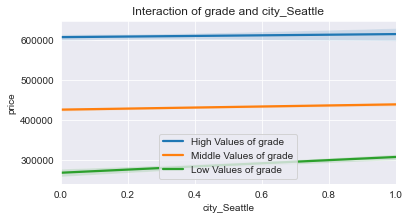

*********************

R^2 including interaction of yr_built and city_Seattle: 0.714


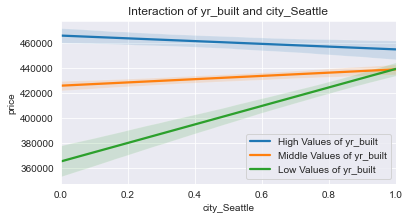

*********************

R^2 including interaction of sqft_living15 and city_Federal Way: 0.713


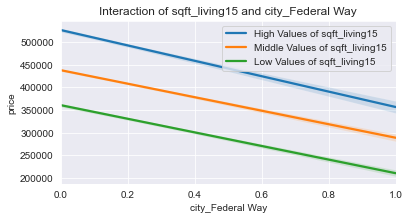

*********************

R^2 including interaction of sqft_living and sqft_basement: 0.713


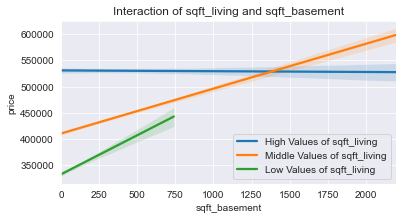

*********************

R^2 including interaction of sqft_living and lat: 0.713


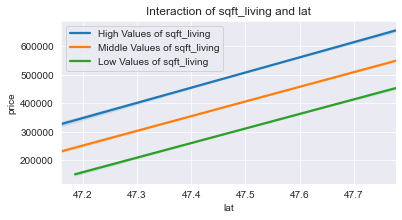

*********************

R^2 including interaction of sqft_living and city_Federal Way: 0.713


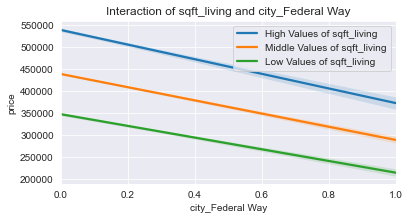

*********************

R^2 including interaction of long and city_Kent: 0.713


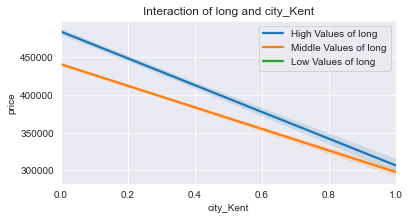

*********************

R^2 including interaction of lat and sqft_living15: 0.713


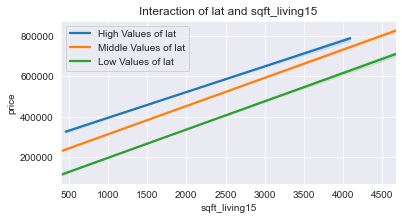

*********************

R^2 including interaction of grade and lat: 0.713


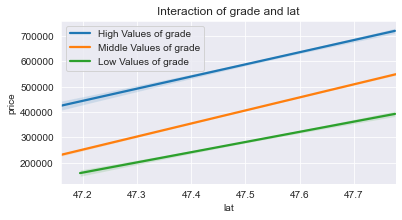

*********************

R^2 including interaction of grade and city_Federal Way: 0.713


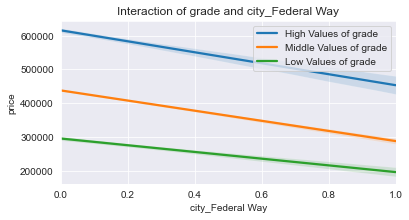

*********************

R^2 including interaction of sqft_living and view: 0.712


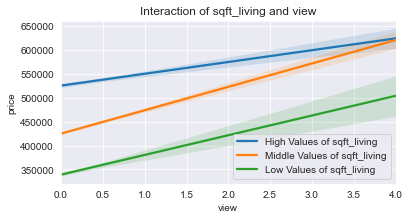

*********************

R^2 including interaction of sqft_living and sqft_living15: 0.712


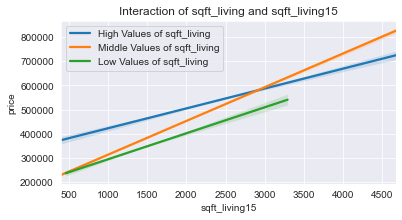

*********************



In [246]:
interactions = find_interactions(15, model_prim, X_train)

In [247]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('yr_built', 'long'),
 ('grade', 'city_Seattle'),
 ('yr_built', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'sqft_basement'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'city_Federal Way'),
 ('long', 'city_Kent'),
 ('lat', 'sqft_living15'),
 ('grade', 'lat'),
 ('grade', 'city_Federal Way'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15')]

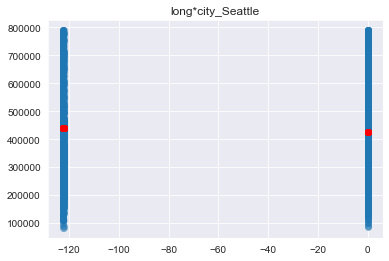

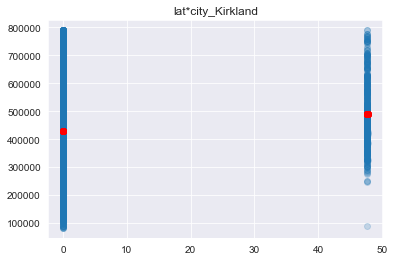

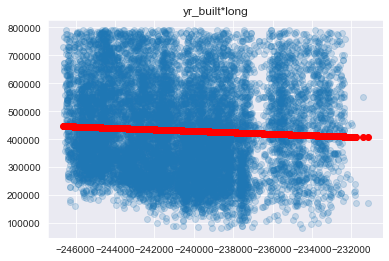

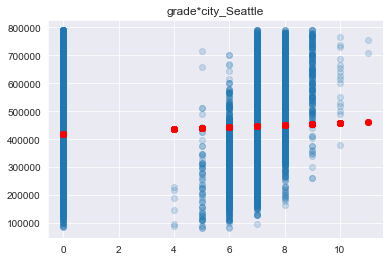

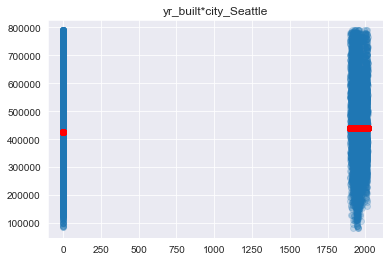

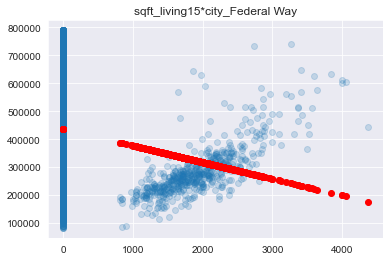

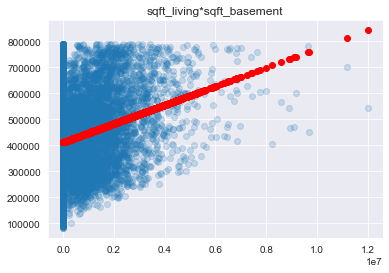

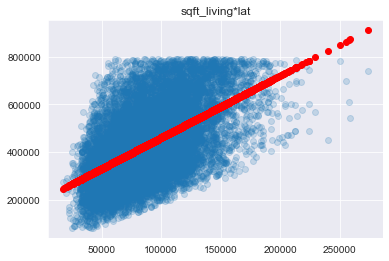

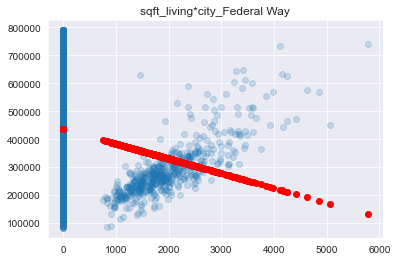

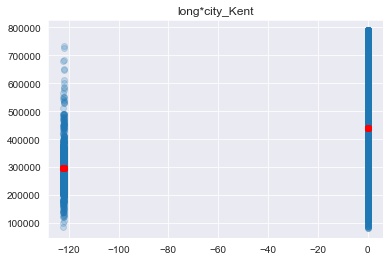

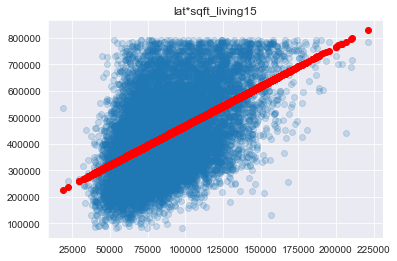

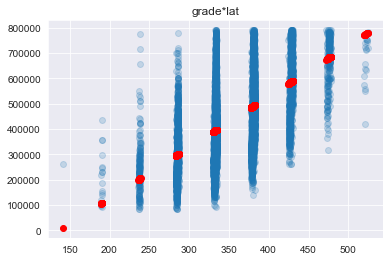

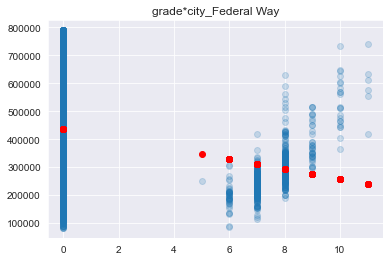

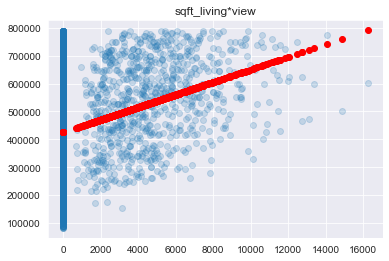

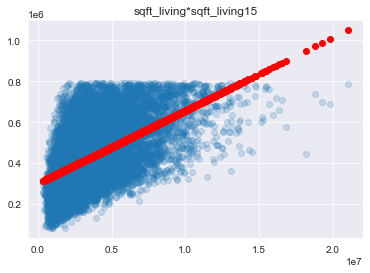

In [248]:
for inter in interactions:
    var = pd.DataFrame(X_train[inter[0]] * X_train[inter[1]])
    linreg = LinearRegression()
    model = linreg.fit(var, y_train)
    y_pred = model.predict(var)
    plt.scatter(var, y_train, alpha=.2)
    plt.scatter(var, y_pred, c='red')
    plt.title('{}*{}'.format(inter[0], inter[1]))
    plt.show()

In [249]:
remove = [('yr_built', 'long'),
          ('yr_built', 'city_Seattle')]
for inter in remove:
    interactions.remove(inter)

In [250]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('grade', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'sqft_basement'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'city_Federal Way'),
 ('long', 'city_Kent'),
 ('lat', 'sqft_living15'),
 ('grade', 'lat'),
 ('grade', 'city_Federal Way'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15')]

In [251]:
%run -i "functions/add_interactions.py"

In [252]:
model_int, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train, X_test)

Interaction Added: long * city_Seattle
Current R^2: 0.7181
Current Test MSE: 7398263903.27847
Current MSE Difference: -7398263902.56037

Interaction Added: grade * city_Seattle
Current R^2: 0.7216
Current Test MSE: 7321813995.57335
Current MSE Difference: -7321813994.85175

Interaction Added: sqft_living * sqft_basement
Current R^2: 0.72351
Current Test MSE: 7263370627.24178
Current MSE Difference: -7263370626.51827

Interaction Added: lat * city_Kirkland
Current R^2: 0.72682
Current Test MSE: 7131718589.93686
Current MSE Difference: -7131718589.21004

Interaction Added: sqft_living * lat
Current R^2: 0.73006
Current Test MSE: 7105996373.99863
Current MSE Difference: -7105996373.26857

Interaction Added: grade * city_Federal Way
Current R^2: 0.73079
Current Test MSE: 7086722393.2681
Current MSE Difference: -7086722392.53731

Interaction Added: sqft_living * view
Current R^2: 0.73127
Current Test MSE: 7091308640.64946
Current MSE Difference: -7091308639.91819

Interaction Added: long * 

In [261]:
from sklearn.model_selection import cross_val_score
%run -i "functions/report.py"

In [264]:
X_train2 = sm.add_constant(X_train2)
X_test2 = sm.add_constant(X_test2)

training_model(feat_cols, outcome, y_train, X_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     719.0
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:52:47   Log-Likelihood:            -1.6508e+05
No. Observations:               12958   AIC:                         3.303e+05
Df Residuals:                   12908   BIC:                         3.306e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                            -1.307e+07   3.44e+06     -3.800      0.000   -1.98e+07   -6.33e+06
bedrooms                         -1.159e+04   1125.101    -10.302      0.000   -1.38e+04   -9384.897
bathrooms                         1.894e+04   1859.000     10.188      0.000    1.53e+04    2.26e+04
sqft_living                      -1627.9035    535.803     -3.038      0.002   -2678.156    -577.651
floors                            1.845e+04   2041.078      9.038      0.000    1.44e+04    2.24e+04
waterfront                        8.115e+04   1.79e+04      4.529      0.000     4.6e+04    1.16e+05
view                              3.916e+04   4231.848      9.255      0.000    3.09e+04    4.75e+04
condition                         1.717e+04   1259.317     13.638      0.000    1.47e+04    1.96e+04
grade                             4.148e+04   1519.007     27.308      0.000    3.85e+04    4.45e+04
sqft_basement                       34.3175      7.141      4.806      0.000      20.321      48.315
yr_built                         -1153.2139     42.442    -27.172      0.000   -1236.406   -1070.022
renovated                          826.2430   4715.795      0.175      0.861   -8417.412    1.01e+04
lat                               3.336e+05    2.2e+04     15.160      0.000     2.9e+05    3.77e+05
long                              6148.5613   2.62e+04      0.235      0.814   -4.52e+04    5.75e+04
sqft_living15                    -1040.5968    707.698     -1.470      0.141   -2427.789     346.595
city_Bellevue                     1.198e+05   6225.590     19.240      0.000    1.08e+05    1.32e+05
city_Black Diamond                9.814e+04   1.21e+04      8.084      0.000    7.43e+04    1.22e+05
city_Bothell                     -6.383e+04   9715.311     -6.570      0.000   -8.29e+04   -4.48e+04
city_Carnation                   -3.345e+04    1.4e+04     -2.396      0.017   -6.08e+04   -6088.907
city_Duvall                      -8.786e+04   1.18e+04     -7.446      0.000   -1.11e+05   -6.47e+04
city_Enumclaw                     6.188e+04   9410.168      6.576      0.000    4.34e+04    8.03e+04
city_Fall City                    3.249e+04   1.55e+04      2.093      0.036    2057.264    6.29e+04
city_Federal Way                  1.272e+05   3.73e+04      3.410      0.001    5.41e+04       2e+05
city_Issaquah                     9.637e+04   7717.916     12.487      0.000    8.12e+04    1.12e+05
city_Kenmore                      -7.13e+04   8539.088     -8.349      0.000    -8.8e+04   -5.46e+04
city_Kent                         2.995e+07    6.7e+06      4.469      0.000    1.68e+07    4.31e+07
city_Kirkland                     1.262e+08   8.04e+06     15.694      0.000     1.1e+08    1.42e+08
city_Maple Valley                 1.954e+04   7189.13

In [265]:
model_int = sm.OLS(y_train, X_train2).fit()

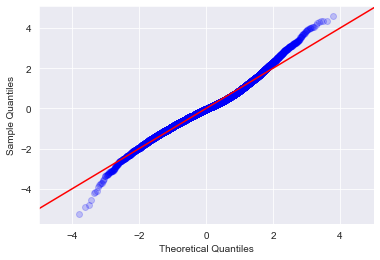

In [266]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_int.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [269]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_int.predict(X_train2)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_int.predict(X_test2)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 82504.87131307248 
 Test RMSE: 84111.85548279253
Percent change:  1.948
Percent change (Base Model vs. Model-Outliers Removed):  -46.723


# Appendix: Models That Didn't Make It

### Model: Dummy Bedrooms

### Model: Binning Bathrooms

Working from the prim dataset (2std deviations removed from low end, and price cut off at <= 1,000,000)

##### Update: No improvement. To the Appendix with you!

In [225]:
bins = [0,1,2,3,4,5,6,7,8]
upHouse_data_prim['bathroom_bins'] = pd.cut(upHouse_data_prim['bathrooms'], bins ,include_lowest = True)

<ipython-input-225-922f3709db6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upHouse_data_prim['bathroom_bins'] = pd.cut(upHouse_data_prim['bathrooms'], bins ,include_lowest = True)


In [226]:
upHouse_data_prim['bathroom_bins'] = upHouse_data_prim['bathroom_bins'].cat.codes
upHouse_data_prim['bathroom_bins'].value_counts()

<ipython-input-226-cc44b35ac9de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upHouse_data_prim['bathroom_bins'] = upHouse_data_prim['bathroom_bins'].cat.codes


2    7846
1    6083
0    3864
3     673
4      42
5       3
7       1
Name: bathroom_bins, dtype: int64

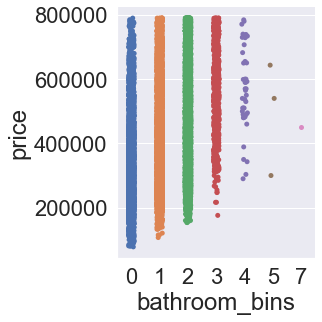

In [227]:
sns.catplot(x="bathroom_bins", y="price", data=upHouse_data_prim);

In [228]:
upHouse_data_prim.drop('bathrooms', axis=1, inplace=True)

In [230]:
# Update column names
feat_cols = list(upHouse_data_prim.columns)
feat_cols.remove(outcome)

In [231]:
X = upHouse_data_prim[feat_cols]
y = upHouse_data_prim['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

training_model(feat_cols, outcome, y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     557.1
Date:                Fri, 20 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:42:30   Log-Likelihood:            -1.6303e+05
No. Observations:               12958   AIC:                         3.263e+05
Df Residuals:                   12862   BIC:                         3.270e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.817e+05   1.04e+05      6.558      0.000    4.78e+05    8.85e+05
bedrooms       -2745.9432    965.169     -2.845      0.004   -4637.817    -854.069
sqft_living       60.3736      9.385      6.433      0.000      41.977      78.770
floors         -1.921e+04   1892.535    -10.148      0.000   -2.29e+04   -1.55e+04
waterfront      1.051e+05   1.73e+04      6.090      0.000    7.13e+04    1.39e+05
sqft_above        34.7151      9.413      3.688      0.000      16.263      53.167
sqft_basement     -0.5679      9.306     -0.061      0.951     -18.810      17.674
yr_built        -331.1592     38.574     -8.585      0.000    -406.769    -255.549
renovated       1.857e+04   4049.339      4.587      0.000    1.06e+04    2.65e+04
sqft_living15     32.4262      1.904     17.035      0.000      28.695      36.157
cond__2         5.067e+04   1.77e+04      2.869      0.004    1.61e+04    8.53e+04
cond__3         8.048e+04   1.65e+04      4.873      0.000    4.81e+04    1.13e+05
cond__4         9.749e+04   1.65e+04      5.900      0.000    6.51e+04     1.3e+05
cond__5         1.263e+05   1.66e+04      7.594      0.000    9.37e+04    1.59e+05
grade__4       -1.104e+05    7.3e+04     -1.511      0.131   -2.54e+05    3.28e+04
grade__5       -1.003e+05   7.12e+04     -1.409      0.159    -2.4e+05    3.93e+04
grade__6       -8.833e+04    7.1e+04     -1.244      0.214   -2.28e+05    5.09e+04
grade__7        -5.89e+04    7.1e+04     -0.829      0.407   -1.98e+05    8.03e+04
grade__8       -2.217e+04    7.1e+04     -0.312      0.755   -1.61e+05    1.17e+05
grade__9        2.762e+04   7.11e+04      0.388      0.698   -1.12e+05    1.67e+05
grade__10       5.128e+04   7.13e+04      0.720      0.472   -8.84e+04    1.91e+05
grade__11       5.096e+04    7.3e+04      0.698      0.485   -9.22e+04    1.94e+05
grade__12      -3.871e-09   3.86e-10    -10.024      0.000   -4.63e-09   -3.11e-09
grade__13       5.467e-09   5.12e-10     10.683      0.000    4.46e-09    6.47e-09
view__1.0        4.14e+04   6025.681      6.871      0.000    2.96e+04    5.32e+04
view__2.0        4.53e+04   3576.891     12.665      0.000    3.83e+04    5.23e+04
view__3.0       7.027e+04   5465.259     12.858      0.000    5.96e+04     8.1e+04
view__4.0       1.158e+05    1.2e+04      9.642      0.000    9.23e+04    1.39e+05
zipcode__98002 -1723.9593   7405.181     -0.233      0.816   -1.62e+04    1.28e+04
zipcode__98003 -4688.5723   6730.141     -0.697      0.486   -1.79e+04    8503.503
zipcode__98004  4.167e+05   1.18e+04     35.284      0.000    3.94e+05     4.4e+05
zipcode__98005   2.89e+05   9950.413     29.046      0.000     2.7e+05    3.09e+05
zipcode__98006  2.311e+05   6837.823     33.797      0.000    2.18e+05    2.45e+05
zipcode__98007  2.364e+05   9449.731     25.016      0.000    2.18e+05    2.55e+05
zipcode__980

In [232]:
model_prim_bin = sm.OLS(y_train, X_train).fit()

In [233]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train = model_prim_bin.predict(X_train)
rmse_train = mse(y_train, y_hat_train)**0.5
y_hat_test = model_prim_bin.predict(X_test)
rmse_test = mse(y_test, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
print('Percent change (Base Model vs. Model-Outliers Removed): ', round(((rmse_test-157877.62035823576)/157877.62035823576)*100, 3))


Train RMSE: 70448.84008612919 
 Test RMSE: 71761.20392343133
Percent change:  1.863
Percent change (Base Model vs. Model-Outliers Removed):  -54.546


### Model 3: Log Transformation to Price (y-variable)


In [41]:
# Transform y_train_out and y_test_out with np.log
y_train_log = np.log(y_train_out)
y_test_log = np.log(y_test_out)
# Check that Model 2 and Model 3's y variables match
print(len(y_train_log), len(y_train_out))

14529 14529


In [42]:
training_model(feat_cols, outcome, y_train_log, X_train_out)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     829.6
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:25:51   Log-Likelihood:                 4372.9
No. Observations:               14529   AIC:                            -8552.
Df Residuals:                   14432   BIC:                            -7816.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.2819      0.254     52.329      0.000      12.784      13.779
bedrooms          -0.0032      0.002     -1.498      0.134      -0.007       0.001
bathrooms          0.0356      0.004      9.606      0.000       0.028       0.043
sqft_living        0.0001   2.04e-05      5.274      0.000    6.75e-05       0.000
floors            -0.0383      0.004     -8.669      0.000      -0.047      -0.030
waterfront         0.3702      0.032     11.471      0.000       0.307       0.433
sqft_above         0.0001   2.04e-05      5.746      0.000    7.73e-05       0.000
sqft_basement   3.135e-05   2.02e-05      1.553      0.120   -8.21e-06    7.09e-05
yr_built          -0.0007   9.07e-05     -7.991      0.000      -0.001      -0.001
renovated          0.0633      0.009      6.863      0.000       0.045       0.081
sqft_living15   8.382e-05   4.23e-06     19.817      0.000    7.55e-05    9.21e-05
cond__2            0.0930      0.044      2.123      0.034       0.007       0.179
cond__3            0.2052      0.041      5.024      0.000       0.125       0.285
cond__4            0.2475      0.041      6.057      0.000       0.167       0.328
cond__5            0.3058      0.041      7.438      0.000       0.225       0.386
grade__4          -0.4492      0.186     -2.421      0.015      -0.813      -0.086
grade__5          -0.3998      0.181     -2.211      0.027      -0.754      -0.045
grade__6          -0.2904      0.180     -1.610      0.108      -0.644       0.063
grade__7          -0.1687      0.180     -0.935      0.350      -0.522       0.185
grade__8          -0.0729      0.180     -0.404      0.686      -0.427       0.281
grade__9           0.0141      0.181      0.078      0.938      -0.340       0.368
grade__10          0.0306      0.181      0.169      0.866      -0.324       0.385
grade__11          0.0202      0.181      0.111      0.911      -0.335       0.376
grade__12         -0.0368      0.198     -0.186      0.853      -0.425       0.352
grade__13       1.118e-14    8.3e-16     13.473      0.000    9.55e-15    1.28e-14
view__1.0          0.1004      0.014      7.328      0.000       0.074       0.127
view__2.0          0.1063      0.008     13.042      0.000       0.090       0.122
view__3.0          0.1721      0.011     15.066      0.000       0.150       0.195
view__4.0          0.2339      0.018     12.913      0.000       0.198       0.269
zipcode__98002    -0.0378      0.019     -1.967      0.049      -0.075      -0.000
zipcode__98003    -0.0094      0.017     -0.544      0.587      -0.043       0.024
zipcode__98004     1.0338      0.020     52.183      0.000       0.995       1.073
zipcode__98005     0.7262      0.020     35.533      0.000       0.686       0.766
zipcode__98006     0.6100      0.016     39.220      0.000       0.579       0.640
zipcode__980

In [43]:
model3_log = sm.OLS(y_train_log, X_train_out).fit()

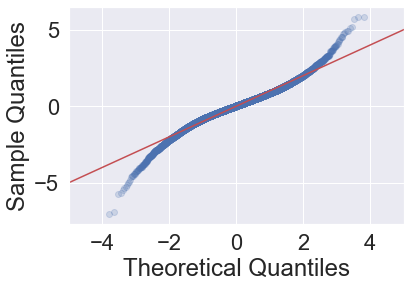

In [44]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model3_log.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [45]:
# We're still dealing with skew here... why
# Probably further trimming ($400,000 - $1,000,000)

In [46]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train3 = model3_log.predict(X_train_out)
rmse_train3 = mse(y_train_log, y_hat_train3)**0.5
y_hat_test3 = model3_log.predict(X_test_out)
rmse_test3 = mse(y_test_log, y_hat_test3)**0.5
print(f'Train RMSE: {rmse_train3} \n Test RMSE: {rmse_test3}')
print('Percent change: ', round(((rmse_test3-rmse_train3)/rmse_train3)*100, 3))

Train RMSE: 0.1790812593145423 
 Test RMSE: 0.18303977494852627
Percent change:  2.21


In [81]:
lessee3 = np.sqrt(mse(np.exp(y_train_log), np.exp(y_hat_train3)))
lessee3

92323.73128717011

In [ ]:
# Lower RMSEs since we log-transformed prices

### Model 4: Addressing Collinearity

In [47]:
# Create a new df that only includes the variable pairs that are correlated
# These variables are our feature variables only
# We'll start with a cutoff of 0.5 to see which have a moderate and above correlation - we may change during modeling
coral = upHouse_data_2std.corr().abs().stack().reset_index().sort_values(0, ascending=False)

coral['pairs'] = list(zip(coral.level_0, coral.level_1))

coral.set_index(['pairs'], inplace = True)

coral.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
coral.columns = ['cc']

coral.drop_duplicates(inplace=True)

coral[(coral.cc>.5) & (coral.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.857486
"(cond__3, cond__4)",0.815930
"(sqft_living15, sqft_living)",0.743393
"(sqft_living, bathrooms)",0.723533
"(sqft_above, sqft_living15)",0.721484
"(bathrooms, sqft_above)",0.646387
"(sqft_living, price)",0.639734
"(bedrooms, sqft_living)",0.585192
"(sqft_living15, price)",0.579969


In [48]:
# Include price to determine which to keep
# Drop cond_3, yr_built, floors
# Interaction: Sqft_living+Sqft_above

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

sqft_above = upHouse_data_2std.sqft_above.values.reshape(-1, 1)
sqft_living = upHouse_data_2std.sqft_living.values.reshape(-1, 1)
sqft_living15 = upHouse_data_2std.sqft_living15.values.reshape(-1, 1)
price = upHouse_data_2std.price.values.reshape(-1, 1)


regression_1.fit(sqft_above, price)
regression_2.fit(sqft_living, price)
regression_3.fit(sqft_living15, price)

# Make predictions using the testing set
pred_1 = regression_1.predict(sqft_above)
pred_2 = regression_2.predict(sqft_living)
pred_3 = regression_2.predict(sqft_living15)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[[164.70243184]]
[[179.82941853]]
[[205.87981237]]


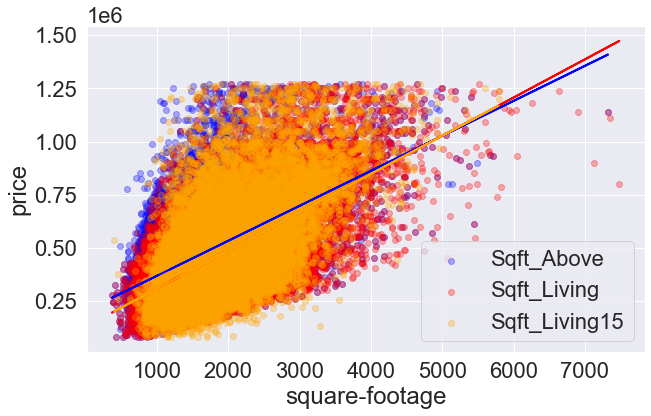

In [51]:
plt.figure(figsize=(10,6))

plt.scatter(sqft_above, upHouse_data_2std.price,  color='blue', alpha=0.3, label = 'Sqft_Above')
plt.scatter(sqft_living, upHouse_data_2std.price,  color='red', alpha=0.3, label = 'Sqft_Living')
plt.scatter(sqft_living15, upHouse_data_2std.price,  color='orange', alpha=0.3, label = 'Sqft_Living15')

plt.plot(sqft_above, pred_1, color='blue', linewidth=2)
plt.plot(sqft_living, pred_2, color='red', linewidth=2)
plt.plot(sqft_living15, pred_3, color='orange', linewidth=2)
plt.ylabel('price')
plt.xlabel('square-footage')
plt.legend();

In [61]:
X_interact_train = X_train_out.copy()
X_interact_test = X_test_out.copy()
X_interact_train['sqft_living-above'] = X_train_out['sqft_above'] * X_train_out['sqft_living']
X_interact_test['sqft_living-above'] = X_test_out['sqft_above'] * X_test_out['sqft_living']
X_interact_train.drop(columns=['sqft_living', 'sqft_above', 'sqft_living15'], inplace=True)
X_interact_test.drop(columns=['sqft_living', 'sqft_above', 'sqft_living15'], inplace=True)

In [62]:
# Drop cond_3, yr_built, floors, grade_7, grade_8
X_interact_train.drop(['cond__3', 'yr_built', 'floors', 'bathrooms', 'grade__7', 'grade__8'], axis=1, inplace=True)
X_interact_test.drop(['cond__3', 'yr_built', 'floors','bathrooms', 'grade__7', 'grade__8'], axis=1, inplace=True)

In [63]:
training_model(feat_cols, outcome, y_train_log, X_interact_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     710.9
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:11:15   Log-Likelihood:                 2914.3
No. Observations:               14529   AIC:                            -5651.
Df Residuals:                   14440   BIC:                            -4976.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.2197      0.014    861.994      0.000      12.192      12.247
bedrooms              0.0185      0.002      8.343      0.000       0.014       0.023
waterfront            0.3488      0.036      9.785      0.000       0.279       0.419
sqft_basement      8.523e-05   4.49e-06     18.972      0.000    7.64e-05     9.4e-05
renovated             0.0841      0.010      8.633      0.000       0.065       0.103
cond__2              -0.1224      0.019     -6.603      0.000      -0.159      -0.086
cond__4               0.0399      0.004      9.852      0.000       0.032       0.048
cond__5               0.1078      0.007     16.545      0.000       0.095       0.121
grade__4             -0.3902      0.049     -8.033      0.000      -0.485      -0.295
grade__5             -0.3189      0.016    -19.956      0.000      -0.350      -0.288
grade__6             -0.1888      0.006    -31.047      0.000      -0.201      -0.177
grade__9              0.1559      0.006     25.247      0.000       0.144       0.168
grade__10             0.1494      0.010     14.458      0.000       0.129       0.170
grade__11             0.0791      0.020      4.029      0.000       0.041       0.118
grade__12             0.0639      0.090      0.712      0.477      -0.112       0.240
grade__13          5.137e-10    4.1e-11     12.517      0.000    4.33e-10    5.94e-10
view__1.0             0.1518      0.015     10.061      0.000       0.122       0.181
view__2.0             0.1534      0.009     17.216      0.000       0.136       0.171
view__3.0             0.2402      0.013     19.190      0.000       0.216       0.265
view__4.0             0.3159      0.020     15.894      0.000       0.277       0.355
zipcode__98002       -0.0622      0.021     -2.932      0.003      -0.104      -0.021
zipcode__98003       -0.0018      0.019     -0.093      0.926      -0.039       0.036
zipcode__98004        1.0931      0.022     50.241      0.000       1.050       1.136
zipcode__98005        0.8099      0.022     36.065      0.000       0.766       0.854
zipcode__98006        0.6675      0.017     39.109      0.000       0.634       0.701
zipcode__98007        0.6678      0.024     27.821      0.000       0.621       0.715
zipcode__98008        0.6467      0.019     34.094      0.000       0.610       0.684
zipcode__98010        0.2632      0.026     10.122      0.000       0.212       0.314
zipcode__98011        0.4650      0.021     22.014      0.000       0.424       0.506
zipcode__98014        0.3684      0.025     14.922      0.000       0.320       0.417
zipcode__98019        0.3590      0.021     17.267      0.000       0.318       0.400
zipcode__98022        0.0645      0.020      3.259      0.001       0.026       0.103
zipcode__98023       -0.0172      0.016     -1.052      0.293      -0.049

In [64]:
model4_colin = sm.OLS(y_train_log, X_interact_train).fit()

In [65]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train4 = model4_colin.predict(X_interact_train)
rmse_train4 = mse(y_train_log, y_hat_train4)**0.5
y_hat_test4 = model4_colin.predict(X_interact_test)
rmse_test4 = mse(y_test_log, y_hat_test4)**0.5
print(f'Train RMSE: {rmse_train4} \n Test RMSE: {rmse_test4}')
print('Percent change: ', round(((rmse_test4-rmse_train4)/rmse_train4)*100, 3))

Train RMSE: 0.19799308307521132 
 Test RMSE: 0.2048465922537952
Percent change:  3.461


In [78]:
lessee2 = np.sqrt(mse(np.exp(y_train_log), np.exp(y_hat_train4)))

In [79]:
lessee2

112719.59984391986

### Model 5: Eliminating Non-Sig P-Values

In [66]:
# Extract the p-value table from the summary and use it to subset our features
summary = model4_colin.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
# x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

90 85
['const', 'bedrooms', 'waterfront', 'sqft_basement', 'renovated']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
const,12.2197,0.014,861.994,0.0,12.192,12.247
bedrooms,0.0185,0.002,8.343,0.0,0.014,0.023
waterfront,0.3488,0.036,9.785,0.0,0.279,0.419
sqft_basement,8.523e-05,4.49e-06,18.972,0.0,7.64e-05,9.4e-05
renovated,0.0841,0.010,8.633,0.0,0.065,0.103


In [67]:
len(p_table)

90

In [68]:
X_train_psig = X_interact_train[x_cols]
X_test_psig = X_interact_test[x_cols]

In [70]:
len(X_train_psig)

14529

In [71]:
model5 = sm.OLS(y_train_log, X_train_psig).fit() 

In [72]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     753.6
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:20:52   Log-Likelihood:                 2910.6
No. Observations:               14529   AIC:                            -5653.
Df Residuals:                   14445   BIC:                            -5016.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.2211      0.009   1364.034      0.000      12.204      12.239
bedrooms              0.0185      0.002      8.321      0.000       0.014       0.023
waterfront            0.3500      0.036      9.829      0.000       0.280       0.420
sqft_basement      8.538e-05   4.49e-06     19.022      0.000    7.66e-05    9.42e-05
renovated             0.0844      0.010      8.665      0.000       0.065       0.103
cond__2              -0.1221      0.019     -6.587      0.000      -0.158      -0.086
cond__4               0.0396      0.004      9.775      0.000       0.032       0.047
cond__5               0.1077      0.007     16.538      0.000       0.095       0.121
grade__4             -0.3900      0.049     -8.029      0.000      -0.485      -0.295
grade__5             -0.3168      0.016    -19.862      0.000      -0.348      -0.286
grade__6             -0.1875      0.006    -31.103      0.000      -0.199      -0.176
grade__9              0.1555      0.006     25.228      0.000       0.143       0.168
grade__10             0.1487      0.010     14.422      0.000       0.128       0.169
grade__11             0.0784      0.020      3.997      0.000       0.040       0.117
grade__13          7.162e-11    4.7e-12     15.223      0.000    6.24e-11    8.08e-11
view__1.0             0.1526      0.015     10.120      0.000       0.123       0.182
view__2.0             0.1539      0.009     17.284      0.000       0.136       0.171
view__3.0             0.2416      0.012     19.346      0.000       0.217       0.266
view__4.0             0.3167      0.020     15.934      0.000       0.278       0.356
zipcode__98002       -0.0637      0.018     -3.506      0.000      -0.099      -0.028
zipcode__98004        1.0920      0.019     58.082      0.000       1.055       1.129
zipcode__98005        0.8089      0.020     41.242      0.000       0.770       0.847
zipcode__98006        0.6671      0.013     51.128      0.000       0.642       0.693
zipcode__98007        0.6669      0.021     31.201      0.000       0.625       0.709
zipcode__98008        0.6455      0.015     41.679      0.000       0.615       0.676
zipcode__98010        0.2618      0.024     11.096      0.000       0.216       0.308
zipcode__98011        0.4639      0.018     25.634      0.000       0.428       0.499
zipcode__98014        0.3669      0.022     16.576      0.000       0.324       0.410
zipcode__98019        0.3577      0.018     20.199      0.000       0.323       0.392
zipcode__98022        0.0630      0.016      3.817      0.000       0.031       0.095
zipcode__98024        0.4473      0.028     16.011      0.000       0.393       0.502
zipcode__98027        0.5435      0.013     41.162      0.000       0.518       0.569
zipcode__98028        0.4300      0.015     28.619      0.000       0.401

In [73]:
# Determine RMSE for training and test sets based on y_hat trained on X-training-data
# Maybe put percent difference rather than change
y_hat_train5 = model5.predict(X_train_psig)
rmse_train5 = mse(y_train_log, y_hat_train5)**0.5
y_hat_test5 = model5.predict(X_test_psig)
rmse_test5 = mse(y_test_log, y_hat_test5)**0.5
print(f'Train RMSE: {rmse_train5} \n Test RMSE: {rmse_test5}')
print('Percent change: ', round(((rmse_test5-rmse_train5)/rmse_train5)*100, 3))

Train RMSE: 0.19804276873669566 
 Test RMSE: 0.20489478651345225
Percent change:  3.46


In [77]:
lessee = np.sqrt(mse(np.exp(y_train_log), np.exp(y_hat_train5)))
lessee

112735.06083938933

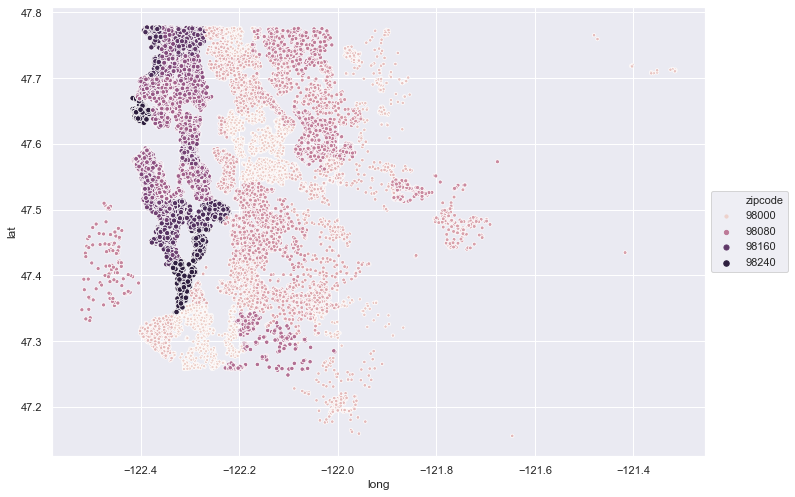

In [85]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(house_data.long, house_data.lat, hue=house_data.zipcode, size=house_data.zipcode,
    sizes=(10, 30))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);

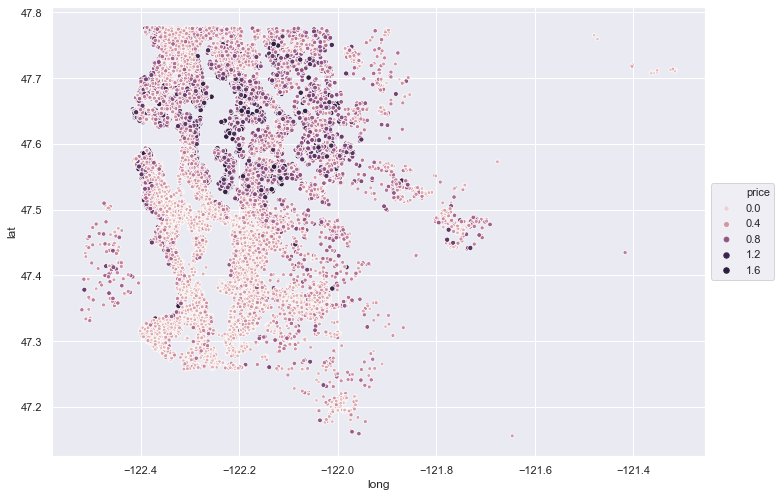

In [83]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(upHouse_data_2std.long, upHouse_data_2std.lat, hue=upHouse_data_2std.price, size=upHouse_data_2std.price,
    sizes=(10, 30))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);